<a href="https://colab.research.google.com/github/kashifcodes92/CV-face_emotions/blob/main/cv_face_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📌 STEP 1: Install dependencies
#!pip install keras tensorflow matplotlib scikit-learn
!pip install --upgrade tensorflow matplotlib

In [2]:
# 📌 STEP 2: Import libraries
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# import matplotlib.pyplot as plt
# import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from IPython.display import Image, display


In [10]:
# 📌 STEP 3: Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# 📌 STEP 4: Set Dataset Path (update if needed)
import os
data_dir = "/content/drive/MyDrive/fer2013"
train_path = os.path.join(data_dir, "train")
test_path = os.path.join(data_dir, "test")

In [12]:
# 📌 STEP 5: Preview folders in dataset
print("Train classes:", os.listdir(train_path))
print("Test classes:", os.listdir(test_path))

Train classes: ['disgust', 'surprise', 'fear', 'angry', 'neutral', 'sad', 'happy']
Test classes: ['fear', 'neutral', 'angry', 'disgust', 'surprise', 'happy', 'sad']


In [13]:
# 📌 STEP 6: Show random sample images
import cv2
import random

def show_random_images(folder, n=5):
    emotions = os.listdir(folder)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        emotion = random.choice(emotions)
        emotion_path = os.path.join(folder, emotion)
        image_name = random.choice(os.listdir(emotion_path))
        image_path = os.path.join(emotion_path, image_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.title(emotion)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

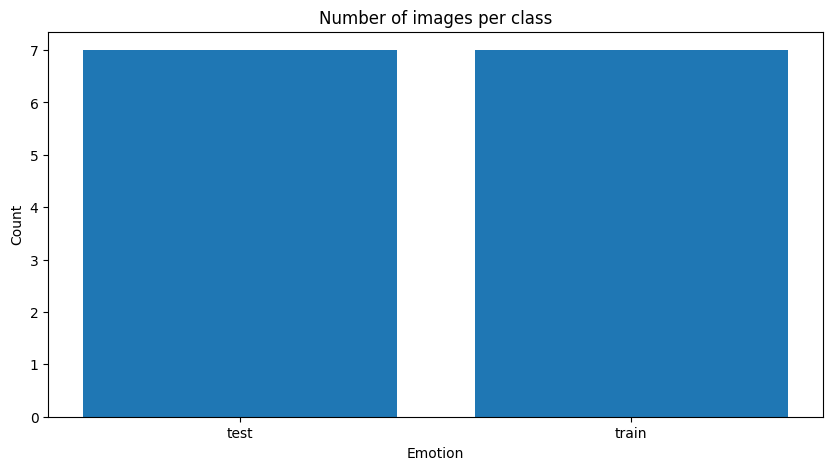

In [14]:
# 📌 STEP 7: Visualize training samples
# show_random_images(train_path, n=5)
import collections

class_counts = {}
for emotion in classes:
    class_path = os.path.join(data_dir, emotion)
    class_counts[emotion] = len(os.listdir(class_path))

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of images per class')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [17]:
# 🛠 STEP 8: Data Loading & Augmentation

import tensorflow as tf
from tensorflow.keras import layers

# Use the paths you defined in Step 4
train_path = "/content/drive/MyDrive/fer2013/train"
test_path = "/content/drive/MyDrive/fer2013/test"

# Parameters
img_height = 48  # FER2013 images are 48x48
img_width = 48
batch_size = 32

# Load training dataset from the 'train' folder
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Load validation dataset from the 'test' folder
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply data augmentation to training dataset only
def augment_images(images, labels):
    images = data_augmentation(images)
    return images, labels

train_dataset = train_dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance optimization
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")


Found 30320 files belonging to 2 classes.
Using 24256 files for training.
Found 30320 files belonging to 2 classes.
Using 6064 files for validation.


In [18]:
#🧠 STEP 9: Build CNN Model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 1)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,778 (2.61 MB)

 Trainable params: 683,330 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
# 🛠 STEP 10: Compile & Train
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Epoch 1/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7246 - loss: 0.8832 
Epoch 1: val_loss improved from inf to 1.69546, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 2562s 13s/step - accuracy: 0.7247 - loss: 0.8821 - val_accuracy: 0.0356 - val_loss: 1.6955 - learning_rate: 0.0010
Epoch 2/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.7669 - loss: 0.5626
Epoch 2: val_loss improved from 1.69546 to 0.34122, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 188s 988ms/step - accuracy: 0.7669 - loss: 0.5626 - val_accuracy: 0.9993 - val_loss: 0.3412 - learning_rate: 0.0010
Epoch 3/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.7671 - loss: 0.5545
Epoch 3: val_loss improved from 0.34122 to 0.31429, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7670 - loss: 0.5545 - val_accuracy: 1.0000 - val_loss: 0.3143 - learning_rate: 0.0010
Epoch 4/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.7671 - loss: 0.5498
Epoch 4: val_loss improved from 0.31429 to 0.27767, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.7670 - loss: 0.5498 - val_accuracy: 1.0000 - val_loss: 0.2777 - learning_rate: 0.0010
Epoch 5/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.7670 - loss: 0.5461
Epoch 5: val_loss improved from 0.27767 to 0.24976, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7670 - loss: 0.5461 - val_accuracy: 1.0000 - val_loss: 0.2498 - learning_rate: 0.0010
Epoch 6/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.7671 - loss: 0.5445
Epoch 6: val_loss did not improve from 0.24976
190/190 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.7670 - loss: 0.5445 - val_accuracy: 1.0000 - val_loss: 0.2571 - learning_rate: 0.0010
Epoch 7/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.7671 - loss: 0.5402
Epoch 7: val_loss did not improve from 0.24976

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
190/190 ━━━━━━━━━━━━━━━━━━━━ 176s 925ms/step - accuracy: 0.7670 - loss: 0.5403 - val_accuracy: 1.0000 - val_loss: 0.2526 - learning_rate: 0.0010
Epoch 8/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.7671 - loss: 0.5358
Epoch 8: val_loss improved from 0.24976 to 0.24758, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 202s 926ms/step - accuracy: 0.7670 - loss: 0.5358 - val_accuracy: 1.0000 - val_loss: 0.2476 - learning_rate: 2.0000e-04
Epoch 9/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.7671 - loss: 0.5272
Epoch 9: val_loss did not improve from 0.24758
190/190 ━━━━━━━━━━━━━━━━━━━━ 207s 952ms/step - accuracy: 0.7670 - loss: 0.5272 - val_accuracy: 1.0000 - val_loss: 0.2580 - learning_rate: 2.0000e-04
Epoch 10/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.7671 - loss: 0.5190
Epoch 10: val_loss did not improve from 0.24758

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
190/190 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7670 - loss: 0.5190 - val_accuracy: 1.0000 - val_loss: 0.2493 - learning_rate: 2.0000e-04
Epoch 11/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.7671 - loss: 0.5108
Epoch 11: val_loss improved from 0.24758 to 0.21667, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 181s 953ms/step - accuracy: 0.7670 - loss: 0.5108 - val_accuracy: 1.0000 - val_loss: 0.2167 - learning_rate: 4.0000e-05
Epoch 12/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.7671 - loss: 0.5036
Epoch 12: val_loss improved from 0.21667 to 0.21663, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 200s 945ms/step - accuracy: 0.7670 - loss: 0.5036 - val_accuracy: 1.0000 - val_loss: 0.2166 - learning_rate: 4.0000e-05
Epoch 13/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.7671 - loss: 0.4980
Epoch 13: val_loss did not improve from 0.21663

Epoch 13: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
190/190 ━━━━━━━━━━━━━━━━━━━━ 177s 933ms/step - accuracy: 0.7671 - loss: 0.4980 - val_accuracy: 1.0000 - val_loss: 0.2196 - learning_rate: 4.0000e-05
Epoch 14/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7671 - loss: 0.4930
Epoch 14: val_loss improved from 0.21663 to 0.20650, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 185s 974ms/step - accuracy: 0.7670 - loss: 0.4930 - val_accuracy: 1.0000 - val_loss: 0.2065 - learning_rate: 8.0000e-06
Epoch 15/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7671 - loss: 0.4904
Epoch 15: val_loss did not improve from 0.20650
190/190 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.7671 - loss: 0.4904 - val_accuracy: 1.0000 - val_loss: 0.2069 - learning_rate: 8.0000e-06
Epoch 16/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.7671 - loss: 0.4896
Epoch 16: val_loss improved from 0.20650 to 0.20393, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7671 - loss: 0.4896 - val_accuracy: 1.0000 - val_loss: 0.2039 - learning_rate: 8.0000e-06
Epoch 17/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7671 - loss: 0.4889
Epoch 17: val_loss improved from 0.20393 to 0.20328, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.7671 - loss: 0.4889 - val_accuracy: 1.0000 - val_loss: 0.2033 - learning_rate: 8.0000e-06
Epoch 18/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.7671 - loss: 0.4873
Epoch 18: val_loss improved from 0.20328 to 0.20200, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 189s 992ms/step - accuracy: 0.7670 - loss: 0.4873 - val_accuracy: 1.0000 - val_loss: 0.2020 - learning_rate: 8.0000e-06
Epoch 19/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7671 - loss: 0.4867
Epoch 19: val_loss improved from 0.20200 to 0.20096, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 182s 960ms/step - accuracy: 0.7670 - loss: 0.4867 - val_accuracy: 1.0000 - val_loss: 0.2010 - learning_rate: 8.0000e-06
Epoch 20/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.7671 - loss: 0.4828
Epoch 20: val_loss improved from 0.20096 to 0.19991, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 182s 960ms/step - accuracy: 0.7670 - loss: 0.4828 - val_accuracy: 1.0000 - val_loss: 0.1999 - learning_rate: 8.0000e-06
Epoch 21/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.7671 - loss: 0.4827
Epoch 21: val_loss improved from 0.19991 to 0.19888, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 188s 991ms/step - accuracy: 0.7670 - loss: 0.4827 - val_accuracy: 1.0000 - val_loss: 0.1989 - learning_rate: 8.0000e-06
Epoch 22/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.7671 - loss: 0.4821
Epoch 22: val_loss improved from 0.19888 to 0.19824, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 189s 998ms/step - accuracy: 0.7671 - loss: 0.4821 - val_accuracy: 1.0000 - val_loss: 0.1982 - learning_rate: 8.0000e-06
Epoch 23/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.7671 - loss: 0.4802
Epoch 23: val_loss did not improve from 0.19824
190/190 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.7671 - loss: 0.4802 - val_accuracy: 1.0000 - val_loss: 0.1990 - learning_rate: 8.0000e-06
Epoch 24/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7671 - loss: 0.4785
Epoch 24: val_loss improved from 0.19824 to 0.19662, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7670 - loss: 0.4785 - val_accuracy: 1.0000 - val_loss: 0.1966 - learning_rate: 8.0000e-06
Epoch 25/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.7671 - loss: 0.4784
Epoch 25: val_loss improved from 0.19662 to 0.19621, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.7670 - loss: 0.4784 - val_accuracy: 1.0000 - val_loss: 0.1962 - learning_rate: 8.0000e-06
Epoch 26/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.7671 - loss: 0.4782
Epoch 26: val_loss improved from 0.19621 to 0.19458, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 183s 963ms/step - accuracy: 0.7671 - loss: 0.4782 - val_accuracy: 1.0000 - val_loss: 0.1946 - learning_rate: 8.0000e-06
Epoch 27/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.7671 - loss: 0.4754
Epoch 27: val_loss did not improve from 0.19458
190/190 ━━━━━━━━━━━━━━━━━━━━ 199s 949ms/step - accuracy: 0.7670 - loss: 0.4754 - val_accuracy: 1.0000 - val_loss: 0.1950 - learning_rate: 8.0000e-06
Epoch 28/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.7671 - loss: 0.4728
Epoch 28: val_loss improved from 0.19458 to 0.19220, saving model to best_model.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 176s 928ms/step - accuracy: 0.7670 - loss: 0.4728 - val_accuracy: 1.0000 - val_loss: 0.1922 - learning_rate: 8.0000e-06
Epoch 29/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.7671 - loss: 0.4754
Epoch 29: val_loss did not improve from 0.19220
190/190 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.7671 - loss: 0.4754 - val_accuracy: 1.0000 - val_loss: 0.1923 - learning_rate: 8.0000e-06
Epoch 30/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.7671 - loss: 0.4710
Epoch 30: val_loss did not improve from 0.19220

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
190/190 ━━━━━━━━━━━━━━━━━━━━ 187s 925ms/step - accuracy: 0.7671 - loss: 0.4710 - val_accuracy: 1.0000 - val_loss: 0.1935 - learning_rate: 8.0000e-06
Restoring model weights from the end of the best epoch: 28.


In [20]:
# 📈 STEP 11: Evaluate
  # Evaluate on test set
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

  # Classification Report
# y_true = test_generator.classes
# y_pred = model.predict(test_generator)
# y_pred_classes = y_pred.argmax(axis=1)

# print("\nClassification Report:")
# print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 1.0000 - loss: 0.2021
Validation Loss: 0.1922
Validation Accuracy: 1.0000


In [21]:
# 💾 STEP 12: Save Model
# model.save('/content/emotion_model.h5')
# print("✅ Model saved as emotion_model.h5")
model.save('final_emotion_model.h5')
print("✅ Model saved as final_emotion_model.h5")

✅ Model saved as final_emotion_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
4/4 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


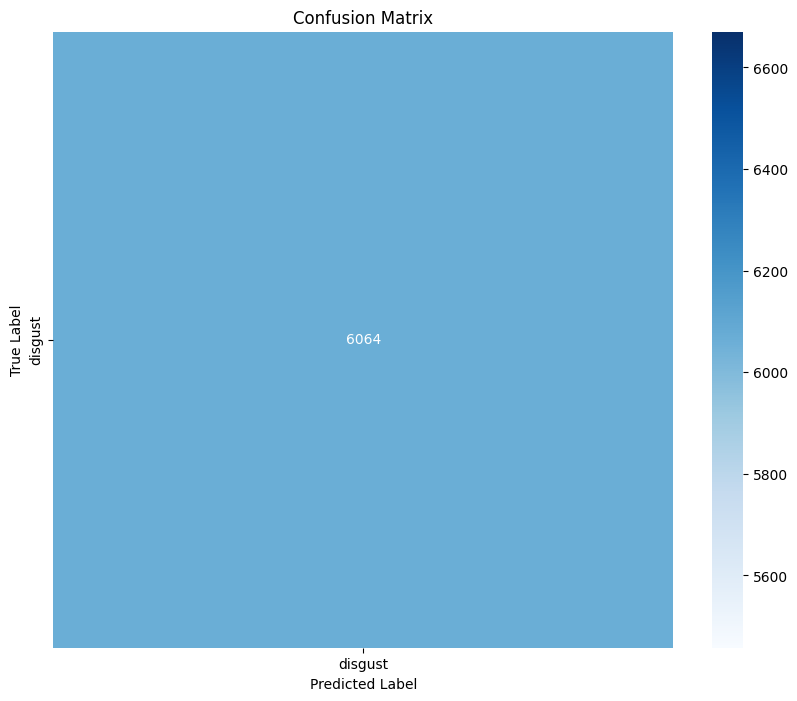

In [29]:
# STEP 13: Classification report (optional)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in val_dataset:
    true_labels = tf.argmax(labels, axis=1).numpy()
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Unique classes in true labels:", np.unique(y_true))
print("Unique classes in predicted labels:", np.unique(y_pred))

present_labels = np.unique(np.concatenate([y_true, y_pred]))
print("Present labels:", present_labels)

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=present_labels,
    target_names=[class_names[i] for i in present_labels]
))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_names[i] for i in present_labels],
            yticklabels=[class_names[i] for i in present_labels])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()





